In [73]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot
import numpy as np

## Loading in the data

In [100]:
data=pd.read_csv("Data/adult_mortality_by_country.csv",header=1)
mortality=data.drop(columns=['Male','Female'])
df=df.rename(columns={"Both sexes": "mortality_rate"})
df['mortality_rate'].describe()
df['Year']=pd.to_datetime(df['Year'],format='%Y')
df=df.groupby(['Country']).mean()
df.describe()

,mortality_rate
count,183.000000
mean,193.530376
std,109.179405
min,59.117647
25%,110.264706
50%,164.882353
75%,252.294118
max,549.352941


##  Visualizing outliers

#### The outliers in the outliers are not real outliers rather variance, apparently some countries really have that high of a mortality rate

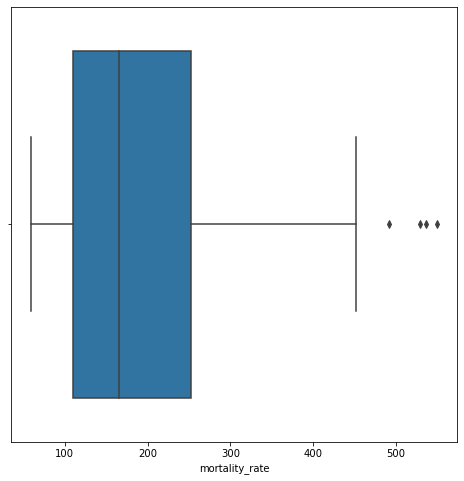

In [101]:
fig, ax= pyplot.subplots(figsize=(8,8))
sns.boxplot(x="mortality_rate", data=df, ax=ax)

In [102]:
df.loc[df["mortality_rate"]>300]

,mortality_rate
Country,
Botswana,431.294118
Burundi,334.941176
Cameroon,375.176471
Central African Republic,491.647059
Chad,391.470588
Congo,341.470588
Côte d'Ivoire,437.117647
Equatorial Guinea,341.588235
Eritrea,322.000000


## Defining Low and High mortality rate

In [90]:
df['mortality_rate'] = np.where(df['mortality_rate'] <150, 'low', 'high') #TODO- SHOULD DOUBLE CHECK WHAT IS HIGH AND LOW MORTALITY
df.head(15)                                                             #FOR NOW CHOSE ACCORDING TO THE QUARTILES

,mortality_rate
Country,
Afghanistan,high
Albania,low
Algeria,low
Angola,high
Antigua and Barbuda,low
Argentina,low
Armenia,low
Australia,low
Austria,low


#### View number of countries with low and high mortality rate

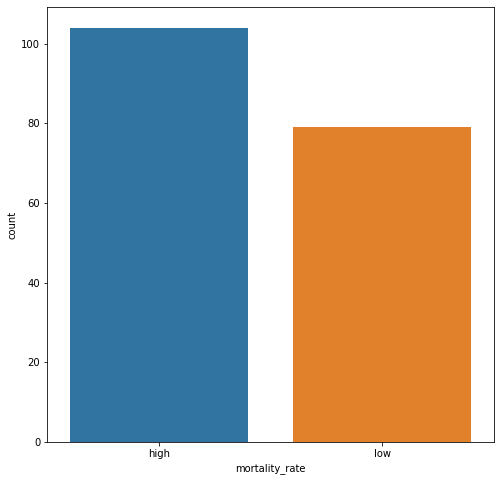

In [96]:
fig, ax= pyplot.subplots(figsize=(8,8))
sns.countplot(x=df['mortality_rate'],ax=ax)